In [1]:
from skimage import metrics
import torch
import numpy as np
import os

## Calculation of RMSE and $\mu_{SIM}$ for VAE

In [9]:
from torch.utils.data import DataLoader
from generative_ai.src.dataloader import DendritePFMDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_dataset = DendritePFMDataset((3, 128, 128), os.path.join("data", "dataset_split.json"), split="test")
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

vae = torch.load(os.path.join("ckpt", "CVAE.ckpt")).to(device)

rmses = []
ssims = []
ys = []
dids = []
# evaluate
with torch.no_grad():
    for iteration, (x, y, did) in enumerate(test_dataloader):

        ys.append(y[0])
        dids.append(did[0])

        # image and control variables
        recon_x = vae.inference(y)

        rmses.append(metrics.normalized_root_mse(x.cpu().numpy()[0].transpose(1, 2, 0), recon_x.cpu().numpy()[0].transpose(1, 2, 0)))
        ssims.append(metrics.structural_similarity(x.cpu().numpy()[0].transpose(1, 2, 0), recon_x.cpu().numpy()[0].transpose(1, 2, 0), win_size=3, data_range=(x.max()-x.min()).item()))


C:\Users\u0178651a\AppData\Local\Temp\ipykernel_49392\865497903.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae = torch.load(os.path.join("ckpt", "CVAE.ckpt")).to(de

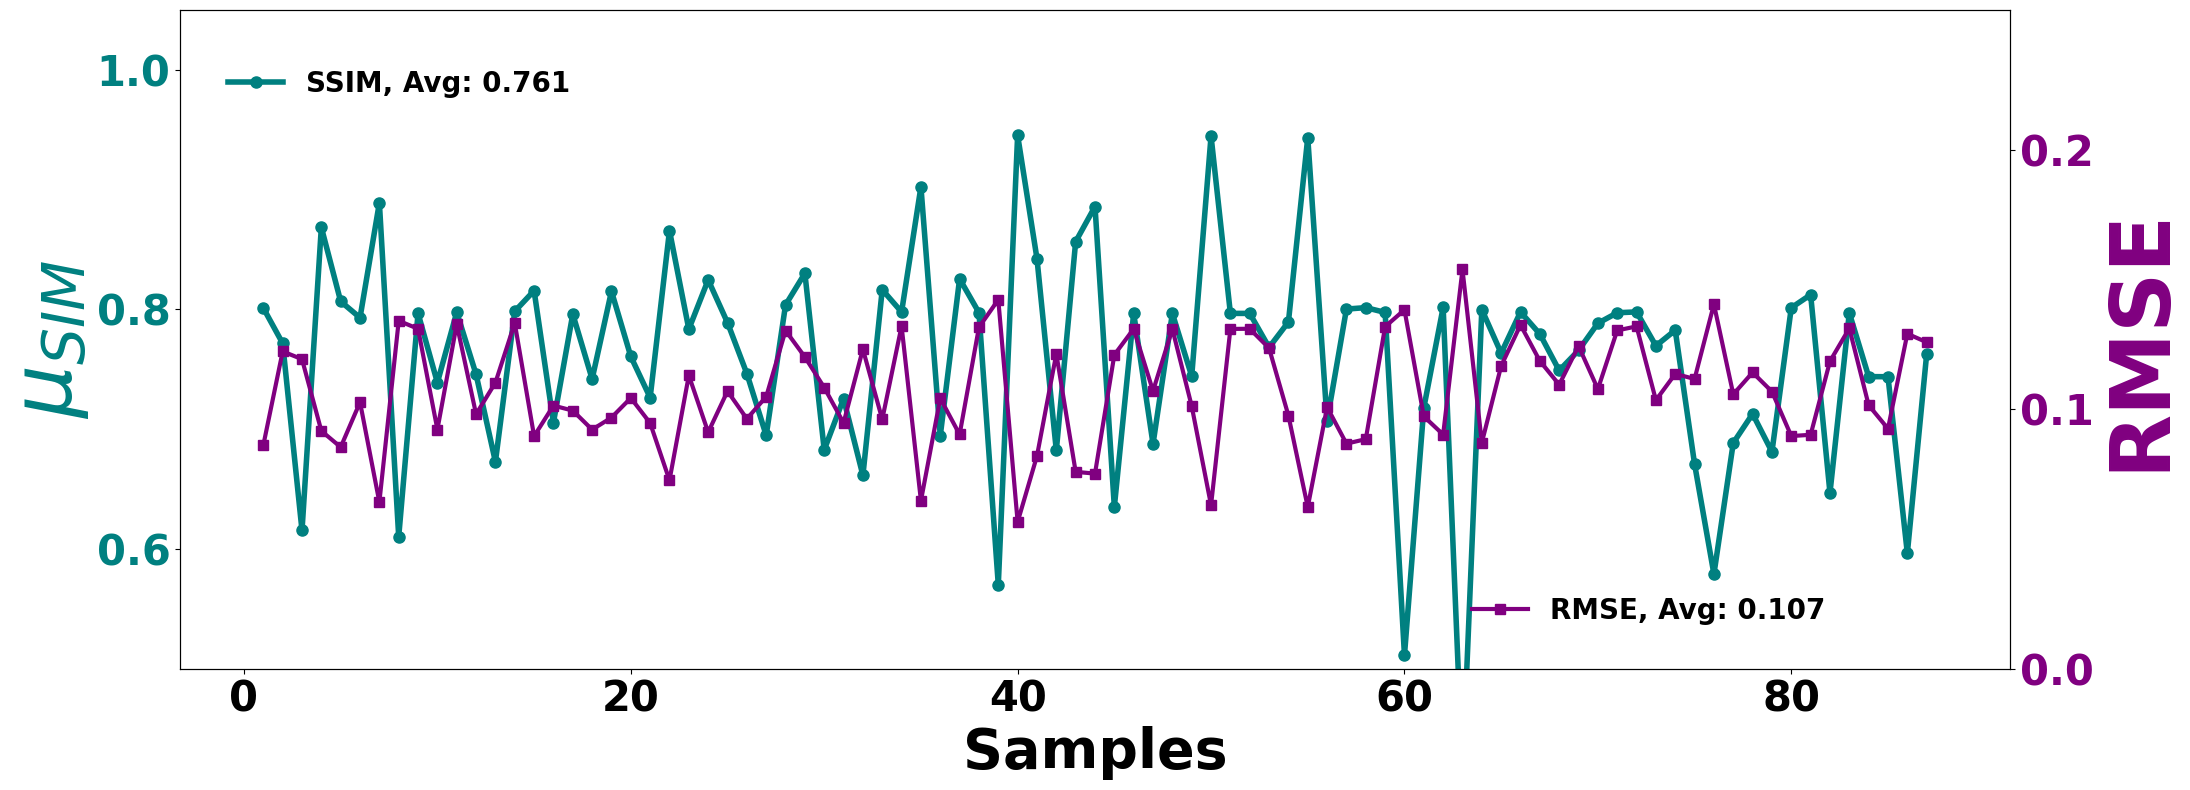

In [14]:
from matplotlib import pyplot as plt

# 可选：平均值
rmse_avg = np.mean(rmses)
ssim_avg = np.mean(ssims)

# 设置全局画布参数
plt.rcParams["figure.figsize"] = (22, 8)

# 创建图和坐标轴
fig, ax1 = plt.subplots()

# 横轴编号
x = np.arange(1, len(rmses) + 1)

# 绘制 SSIM 曲线
ax1.plot(x, ssims, '-o', color='teal', linewidth=4, markersize=8,
         label=f'SSIM, Avg: {ssim_avg:.3f}')
ax1.set_xlabel("Samples", size=40, weight='bold')
ax1.set_ylabel(r"$\mu_{SIM}$", size=60, color='teal', weight='bold')
ax1.tick_params(axis='y', labelcolor='teal', labelsize=30)
ax1.tick_params(axis='x', labelcolor='black', labelsize=30)
ax1.set_ylim([0.5, 1.05])

# 创建右侧轴绘制 RMSE
ax2 = ax1.twinx()
ax2.plot(x, rmses, '-s', color='purple', linewidth=3, markersize=7,
         label=f'RMSE, Avg: {rmse_avg:.3f}')
ax2.set_ylabel("RMSE", size=60, color='purple', weight='bold')
ax2.tick_params(axis='y', labelcolor='purple', labelsize=30)
ax2.set_ylim([0, max(rmses) + 0.1])

# 设置主刻度数量
ax1.xaxis.set_major_locator(plt.MaxNLocator(6))
ax1.yaxis.set_major_locator(plt.MaxNLocator(3))
ax2.yaxis.set_major_locator(plt.MaxNLocator(3))

# 添加图例
ax1.legend(loc=(0.02, 0.85), prop={'weight': 'bold', 'size': 20}, frameon=False)
ax2.legend(loc=(0.7, 0.05), prop={'weight': 'bold', 'size': 20}, frameon=False)

# 加粗坐标轴标签
for label in ax1.get_xticklabels(): label.set_fontweight('bold')
for label in ax1.get_yticklabels(): label.set_fontweight('bold')
for label in ax2.get_yticklabels(): label.set_fontweight('bold')

# 添加标注文字
# plt.text(-0.3, 1.02, "(a)", fontsize=70, weight='bold')

plt.tight_layout()
plt.show()
